# WSI
## Raport z ćwiczenia laboratoryjnego nr 7
### Jan Kuc, 303753

### 1. Cel eksperymentów

Zadanie polega na implementacji algorytmu naiwnego klasyfikatora Bayesa, a następnie przetestowaniu go na zbiorze danych *Cardio Vascular Disease Detection*. Nalezy równiez sprawdzić jakość klasyfikatora metodami: 
- podziału danych na zbiór trenujący, walidacyjny i testowy,
- k-krotnej walidacji krzyzowej dla róznych wartości k.

### 2. Decyzje projektowe

W celu implementacji naiwnego klasyfikatora Bayesa, stworzono klasę **NaiveBayesSolver**, która nie przyjmuje zadnych parametrów inicjujących. Atrybutem klasy jest *data_info*, czyli słownik, który jest wypełniany podczas treningu klasyfikatora (trening to wywołanie metody *fit*) w ten sposób, ze dla kazdej z klas w podanym podczas treningu zbiorze, zapisywane są dane dla kazdego z atrybutów. Dane te, będą potrzebne do wyliczania prawdopodobieństw, dla nowych przykładów. Realizowane jest to w prywatnej metodzie *calculate_probabilities()*, gdzie dla podanego na wejściu wiersza danych, dla wartości kazdego z atrybutów, wyliczane jest prawdopodobieństwo wystąpienia danej wartości pod warunkiem jednoczesnego wystąpienia danej klasy na wyjściu.

Zapisywane informacje dla atrybutów ciągłych to średnia i odchylenie standardowe wartości w kolumnach, dla tych próbek, które na wyjściu dają wybraną klasę. W przypadku atrybutów dyskretnych zapisywane jest prawdopodobieństwo wystąpienia wartości w kolumnie przy danej etykiecie, *czyli suma wystąpień unikalnej wartości*/*liczba wierszy z daną etykietą*. Dla atrybutów ciągłych do wyliczania prawdopodobieństwa zastosowano rozkład normalny.

### 3. Opis eksperymentów

Eksperymenty mające na celu wyłonienie najlepszej metody podziału zaplanowano w ten sposób, ze wybrano kilka roznych stosunków podziałów danych na zbiory (treningowy, walidacyjny i testowy) i dla kazdego z nich, przeprowadzono po 5 uruchomień, co skutkowało w 5 róznych podziałach danych, na których dalej przeprowadzono ewaluację. Kroki ewaluacji to wytrenowanie klasyfikatora na danych uczących, a następnie sprawdzenie skuteczności modelu na danych walidacyjnych. W trakcie ewaluacji zapisywano skuteczności, a następnie dla tych 5 uruchomień wyciągano średnią, by określić który podział daje najlepsze wyniki.

Takie samo podejście zastosowano do k-krotnej walidacji krzyzowej. Dla ustalonej liczby uruchomień testowano rozne krotności walidacji krzyzowej, rowniez dla wielu podziałów.

Ostatecznie sporządzono wykres, na którym przedstawiono wartości precyzji otrzymanych na zbiorach walidacyjnych dla obu metod pomiaru skuteczności. Dla najlepszej z nich, odtworzono podział kilkukrotnie i przetestowano klasyfikator dla tych danych na zbiorze testowym, by uzyskać osteteczny wynik.

### 4. Eksperymenty

In [1]:
import matplotlib.pyplot as plt
from statistics import mean
import sys
sys.path.append('..')
from src.process_data import process_data, dataset_split, cross_validation_split
from src.my_solver import NaiveBayesSolver

In [2]:
FILENAME = '../data/cardio_train.csv'

In [3]:
CLASS_LABEL = 'cardio'

[[<AxesSubplot:title={'center':'age'}>
  <AxesSubplot:title={'center':'gender'}>
  <AxesSubplot:title={'center':'height'}>]
 [<AxesSubplot:title={'center':'weight'}>
  <AxesSubplot:title={'center':'ap_hi'}>
  <AxesSubplot:title={'center':'ap_lo'}>]
 [<AxesSubplot:title={'center':'cholesterol'}>
  <AxesSubplot:title={'center':'gluc'}>
  <AxesSubplot:title={'center':'smoke'}>]
 [<AxesSubplot:title={'center':'alco'}>
  <AxesSubplot:title={'center':'active'}>
  <AxesSubplot:title={'center':'cardio'}>]]
             Missing Values  % of Total Values
age                       0                0.0
gender                    0                0.0
height                    0                0.0
weight                    0                0.0
ap_hi                     0                0.0
ap_lo                     0                0.0
cholesterol               0                0.0
gluc                      0                0.0
smoke                     0                0.0
alco                      

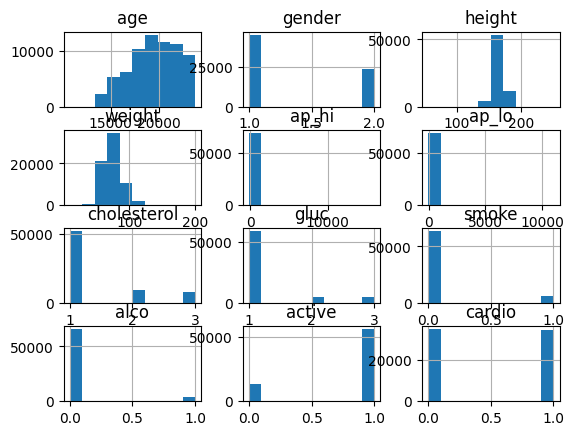

In [4]:
dataset = process_data(FILENAME)

In [5]:
dataset.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,23393,1,155,62.0,120,80,1,1,0,0,1,0


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69301 entries, 0 to 69300
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          69301 non-null  int64  
 1   gender       69301 non-null  int64  
 2   height       69301 non-null  int64  
 3   weight       69301 non-null  float64
 4   ap_hi        69301 non-null  int64  
 5   ap_lo        69301 non-null  int64  
 6   cholesterol  69301 non-null  int64  
 7   gluc         69301 non-null  int64  
 8   smoke        69301 non-null  int64  
 9   alco         69301 non-null  int64  
 10  active       69301 non-null  int64  
 11  cardio       69301 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.3 MB


In [7]:
non_discrete_attrs = ['age', 'weight', 'height', 'ap_hi', 'ap_lo']

In [8]:
dataset[non_discrete_attrs].head()

,age,weight,height,ap_hi,ap_lo
0,22469,69.0,155,130,80
1,14648,71.0,163,110,70
2,21901,70.0,165,120,80
3,14549,85.0,165,120,80
4,23393,62.0,155,120,80


Parametry testowe:

In [9]:
NUM_OF_RUNS = 5
TRAIN_SETS_SIZES = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
FOLDS = range(3,7)

Test dla metody podziału train-validation-test:

In [21]:
tvt_val_accs = {}
for i in range(len(TRAIN_SETS_SIZES)):
    split_accs = []
    split_ratio = (TRAIN_SETS_SIZES[i], round((1-TRAIN_SETS_SIZES[i])/2, 2), round((1-TRAIN_SETS_SIZES[i])/2, 2))
    print(f"For split ratios: {split_ratio}:")
    for j in range(NUM_OF_RUNS):
      train_data_X, train_data_y, valid_data_X, valid_data_y, test_data_X, test_data_y = dataset_split(dataset, CLASS_LABEL, TRAIN_SETS_SIZES[i])
      solver = NaiveBayesSolver()
      val_accuracy = solver.evaluate(train_data_X, train_data_y, valid_data_X, valid_data_y, non_discrete_attrs, CLASS_LABEL)
      print(f"    Split #{j+1}: val_accuracy = {val_accuracy}")
      split_accs.append(val_accuracy)
    print("_"*40)
    tvt_val_accs[mean(split_accs)] = str(split_ratio)

For split ratios: (0.4, 0.3, 0.3):
    Split #1: val_accuracy = 0.5911976911976912
    Split #2: val_accuracy = 0.5744107744107744
    Split #3: val_accuracy = 0.6320346320346321
    Split #4: val_accuracy = 0.5906204906204906
    Split #5: val_accuracy = 0.5634920634920635
________________________________________
For split ratios: (0.5, 0.25, 0.25):
    Split #1: val_accuracy = 0.5826839826839827
    Split #2: val_accuracy = 0.6007503607503607
    Split #3: val_accuracy = 0.6089466089466089
    Split #4: val_accuracy = 0.5418759018759018
    Split #5: val_accuracy = 0.5615007215007215
________________________________________
For split ratios: (0.6, 0.2, 0.2):
    Split #1: val_accuracy = 0.5823953823953824
    Split #2: val_accuracy = 0.5582972582972583
    Split #3: val_accuracy = 0.6074314574314574
    Split #4: val_accuracy = 0.604978354978355
    Split #5: val_accuracy = 0.623015873015873
________________________________________
For split ratios: (0.7, 0.15, 0.15):
    Split #1: v

In [22]:
best_tvt_val_acc = max(tvt_val_accs.keys())
best_split_info = tvt_val_accs[best_tvt_val_acc]
print(f"Best avg accuracy (train-validation-test method) for split ratio: {best_split_info}: {best_tvt_val_acc}")

Best avg accuracy (train-validation-test method) for split ratio: (0.6, 0.2, 0.2): 0.5952236652236652


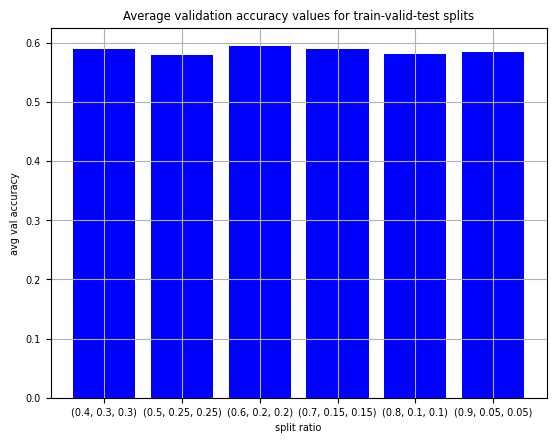

In [23]:
plt.rcParams.update({'font.size': 7})
plt.figure()
plt.grid()
plt.bar(tvt_val_accs.values(), tvt_val_accs.keys(), color ='b')
plt.title("Average validation accuracy values for train-valid-test splits")
plt.xlabel('split ratio')
plt.ylabel('avg val accuracy')
plt.show()

Powyzszy wykres pokazuje, ze najlepszym stosunkiem podziału dla metody train-validation-test okazał się podział 60:20:20. Średnia skuteczność dal tego przypadku wyniosła: **59,52%**.

In [13]:
cross_val_accs = {}
for i in range(len(TRAIN_SETS_SIZES)):
    split_accs = []
    split_ratio = (TRAIN_SETS_SIZES[i], round((1-TRAIN_SETS_SIZES[i])/2, 2), round((1-TRAIN_SETS_SIZES[i])/2, 2))
    print(f"For split ratios: {split_ratio}:")
    for n_fold in FOLDS:
        for j in range(NUM_OF_RUNS):
            X_split, y_split, test_X, test_y = cross_validation_split(dataset, CLASS_LABEL, n_fold, TRAIN_SETS_SIZES[i])
            solver = NaiveBayesSolver()
            eval_dict = solver.evaluate_cross_validation(X_split, y_split, non_discrete_attrs, CLASS_LABEL)
            print(f"  Folds count: {n_fold}:")
            k = 1
            for val_accuracy in eval_dict.keys():
                print(f"    Split #{j+1}, fold #{k}: val_accuracy = {val_accuracy}")
                split_accs.append(val_accuracy)
                k += 1
        print("_"*40)
        cross_val_accs[mean(split_accs)] = f"{split_ratio}, folds={n_fold}"

For split ratios: (0.4, 0.3, 0.3):
  Folds count: 3:
    Split #1, fold #1: val_accuracy = 0.5931354359925789
    Split #1, fold #2: val_accuracy = 0.5813852813852813
    Split #1, fold #3: val_accuracy = 0.5732220160791589
  Folds count: 3:
    Split #2, fold #1: val_accuracy = 0.5711811997526284
    Split #2, fold #2: val_accuracy = 0.5912183055040198
    Split #2, fold #3: val_accuracy = 0.6131725417439703
  Folds count: 3:
    Split #3, fold #1: val_accuracy = 0.6280148423005566
    Split #3, fold #2: val_accuracy = 0.6027829313543599
    Split #3, fold #3: val_accuracy = 0.578726035868893
  Folds count: 3:
    Split #4, fold #1: val_accuracy = 0.5526901669758812
    Split #4, fold #2: val_accuracy = 0.556895485466914
    Split #4, fold #3: val_accuracy = 0.5416821273964131
  Folds count: 3:
    Split #5, fold #1: val_accuracy = 0.6222016079158936
    Split #5, fold #2: val_accuracy = 0.6413110698824984
    Split #5, fold #3: val_accuracy = 0.6048855905998763
______________________

In [18]:
best_cross_val_acc = max(cross_val_accs.keys())
best_split_info = cross_val_accs[best_cross_val_acc]
print(f"Best avg accuracy (cross-validation method) for split ratio: {best_split_info}: {best_cross_val_acc}")

Best avg accuracy (cross-validation method) for split ratio: (0.9, 0.05, 0.05), folds=4: 0.5982373652372405


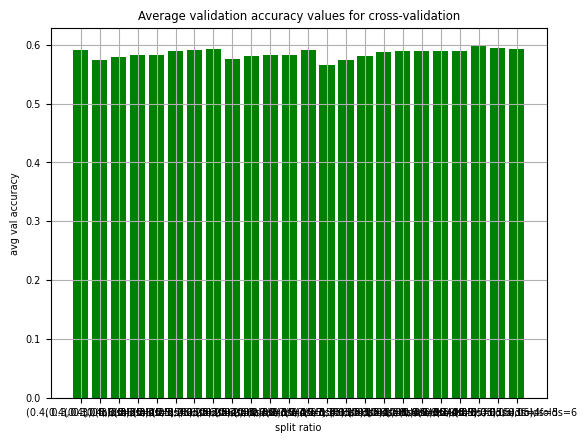

In [20]:
plt.rcParams.update({'font.size': 7})
plt.figure()
plt.grid()
plt.bar(cross_val_accs.values(), cross_val_accs.keys(), color ='g')
plt.title("Average validation accuracy values for cross-validation")
plt.xlabel('split ratio')
plt.ylabel('avg val accuracy')
plt.show()

Na powyszszym wykresie widać, ze najlepszą skuteczność otrzymano dal metody skrośnej walidacji z podziałem: 90:5:5 dla krotności k = 4. Była to wartość **59,82%**

### 5. Wnioski

Uzycie k-krotnej walidacji krzyzowej pozwolilo uzyskać bardzo nieznacznie lepsze wyniki od metody pomiaru skuteczności klasyfikatora z klaycznym podziałem na zbiór treningowy, walidacyjny i testowy. Precyzja naiwnego klasyfikatora Bayesa stworzonego w ramach niniejszego zadania dla kazdego z uruchomień i podziałów danych, stale oscyluje między wartościami ~58% - ~62%.

Sprawdzono skuteczność klasyfikatora na danych testowych, wyłonionych na podstawie podziału, który w wyniku eksperymentów okazał się najlepszy.


In [27]:
best_cross_test_accs = []
for _ in range(NUM_OF_RUNS):
    (
        best_X_split,
        best_y_split,
        best_test_X,
        best_test_y,
    ) = cross_validation_split(dataset, CLASS_LABEL, n_folds=5, train_size=0.9)

    best_cross_accs = solver.evaluate_cross_validation(
        best_X_split,
        best_y_split,
        non_discrete_attrs,
        CLASS_LABEL,
    )

    best_cross_accuracy = max(best_cross_accs.keys())
    best_split = best_cross_accs[best_cross_accuracy]

    best_train_X, best_train_y, _, _ = best_split

    best_cross_test_accs.append(solver.evaluate(best_train_X, best_train_y, best_test_X, best_test_y, non_discrete_attrs, CLASS_LABEL))

print(f"Avg test accuracy for best split (cross-validation method): {mean(best_cross_test_accs)}")

Avg test accuracy for best split (cross-validation method): 0.612463935372187


Średnia skuteczność na zbiorze testowym dla 5 prób: **61,25%**.

Osiągnięte wyniki są gorsze niz w przypadku klasyfikatora zaimplementowawnego w postaci indukcyjnych drzew decyzyjnych ID3, tworzonego w ramach ćwiczenia nr 4. Wtedy równiez działanie solvera testowano na zbiorze danych *Cardio Vascular Disease Detection*, lecz uzyskano skuteczność na zbiorze testowym na poziomie **72,84%**.

Słabszy wynik pokazuje przewagę drzew decyzyjnych nad naiwnym klasyfikatorem Bayesa. Rezultaty mogłyby zostać poprawione poprzez wybranie innego rozkładu zmiennych niedyskretnych niz rozkład ciągły.